In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import os

In [2]:
datadir = '/Users/ashesh.ashesh/Documents/PhD/mbldata_solvation/data_with_tiff'
unused_features = ['hasTiff', 'EventNumber0']

# load train data
datatype = 'train'
with open(os.path.join(datadir,f"{datatype}_ds.bin"), mode="rb") as f:
    data = pickle.load(f)

raw_train_data = data[f"{datatype}_data"]
raw_train_labels = data[f"{datatype}_labels"]
feature_names = data["feature_names"]
clean_mask = raw_train_data[:,-1] > 0
train_data  = raw_train_data[clean_mask,:].copy()
train_labels = raw_train_labels[clean_mask].copy()
# 0, 1 have notiff
# 2, 3 have tiff
# 0,2 => label 0
# 1,3 => label 1
# mask0 = (train_labels == 0) and ()
print(raw_train_data.shape, raw_train_labels.shape)
print(train_data.shape, train_labels.shape)

(362254, 449) (362254,)
(11009, 449) (11009,)


C6818 is 0
Emiliana is 1, 


In [3]:
pd.Series(raw_train_labels).value_counts()

0    255144
1    107110
dtype: int64

In [4]:
pd.Series(train_labels).value_counts()

1    8482
0    2527
dtype: int64

In [5]:
nan_feature_names = np.array(feature_names)[np.isnan(train_data).any(axis=0)].tolist()
nan_feature_names
unused_feature_idx = [feature_names.index(f) for f in nan_feature_names]
unused_feature_idx += [feature_names.index(f) for f in unused_features]

print('Nan features:', nan_feature_names)
print('Unused features:', unused_features)

def get_used_feature_idx():
    valid_feature_idx = []
    for i in range(len(feature_names)):
        if i not in unused_feature_idx:
            valid_feature_idx.append(i)
    return valid_feature_idx

def remove_unused_features(input_data):
    valid_feature_idx = get_used_feature_idx()
    input_data = input_data[:, valid_feature_idx]
    print(input_data.shape, train_labels.shape)
    return input_data

train_data = remove_unused_features(train_data)
raw_train_data = remove_unused_features(raw_train_data)

Nan features: ['PlateLocationY']
Unused features: ['hasTiff', 'EventNumber0']
(11009, 446) (11009,)
(362254, 446) (11009,)


## Just working with relevant data.

In [6]:
# get a validation set
random_indices = np.random.choice(len(train_data), len(train_data), replace=False)
val_N = int(0.1*len(train_data))
print(val_N)
valid_data = train_data[random_indices[-val_N:]]
valid_labels = train_labels[random_indices[-val_N:]]

train_data = train_data[random_indices[:-val_N]]
train_labels = train_labels[random_indices[:-val_N]]

print(train_data.shape, valid_data.shape)

1100
(9909, 446) (1100, 446)


In [20]:
# LightGBM hyper-params
params = {
    "task": "train",
    "boosting_type": "gbdt",       # gbdt, rf, dart, goss
    "n_estimators": 1,
    "objective": "binary",
    "metric": "binary_logloss",
    "is_unbalanced": True,
    "learning_rate": 0.02,
    "max_depth": 20,
    "num_leaves": 200,             # careful for time & overfit
    # "min_data_in_leaf": 1,        # incearse if overfit
    "max_bin": 35000,
    # "bagging_fraction": 0.8,
    # "bagging_freq": 5,
    # "lambda_l1": 0.1,
    # "lambda_l2": 0.5,
    # "path_smooth": 2.0,
    "n_jobs": 2,
    "device_type": "cpu",
    "seed": 777,
    "verbosity": -1
}

In [21]:
train_labels_df = pd.Series(train_labels)
train_labels_df.name = 'target'

cls_count = train_labels_df.value_counts(normalize = True)
WEIGHTS = cls_count.min() / cls_count
train_weights = pd.DataFrame(train_labels_df.rename('old_target')).merge(WEIGHTS, 
                            how = 'left', 
                            left_on = 'old_target', 
                            right_on = WEIGHTS.index).target.values


In [22]:
pd.Series(train_weights).value_counts()

0.300052    7622
1.000000    2287
dtype: int64

In [23]:

lgb_model = lgb.LGBMClassifier()
lgb_model.set_params(**params)

lgb_model.fit(
    train_data, train_labels,
    train_weights,
    eval_set=[
        (train_data, train_labels),  # train
        (valid_data, valid_labels)   # validation
    ],
    eval_names=["train", "validation"], eval_metric=["binary_logloss"],
    callbacks=[lgb.early_stopping(stopping_rounds=15), lgb.log_evaluation(50, True)],
    feature_name=np.array(feature_names)[get_used_feature_idx()].tolist(),
)

Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[1]	train's binary_logloss: 0.673618	validation's binary_logloss: 0.673559


LGBMClassifier(device_type='cpu', is_unbalanced=True, learning_rate=0.02,
               max_bin=35000, max_depth=20, metric='binary_logloss',
               n_estimators=1, n_jobs=2, num_leaves=200, objective='binary',
               seed=777, task='train', verbosity=-1)

In [24]:
# lgb.plot_metric(lgb_model)

In [25]:
# with open("lgb_model_448_cols.bin", mode="rb") as f:
    # lgb_model = pickle.load(f)

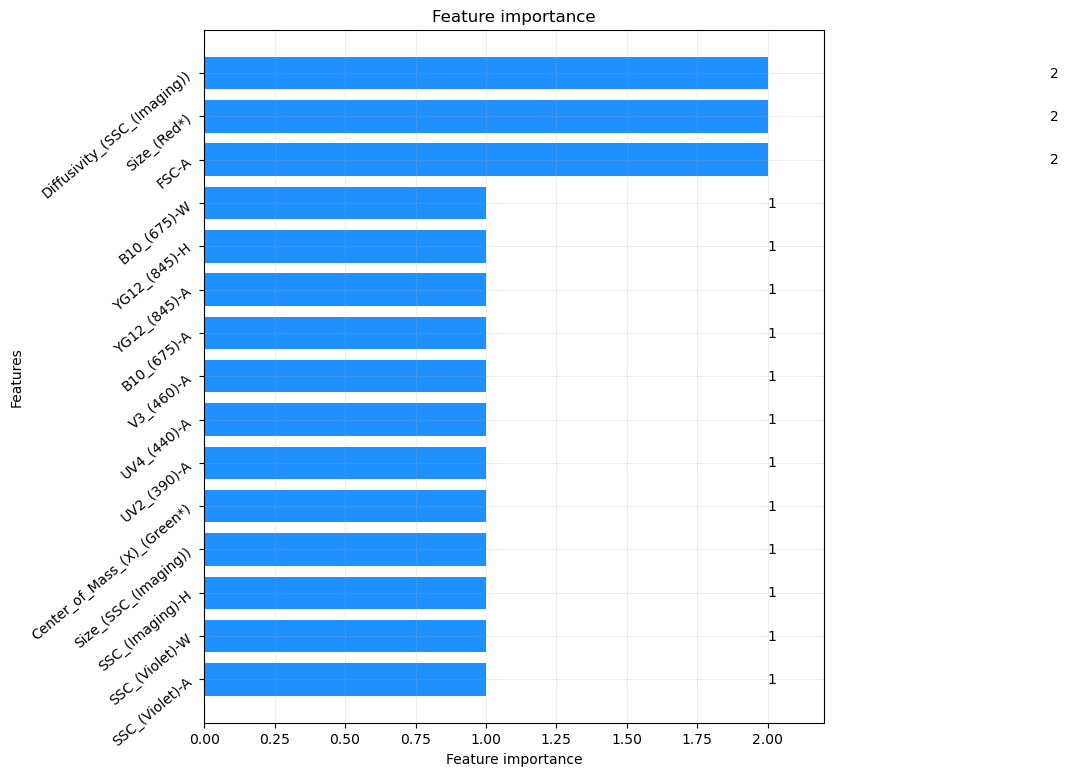

In [26]:
ax = lgb.plot_importance(
    lgb_model, max_num_features=30, importance_type="split",
    figsize=(8, 9), height=0.75,
    color="dodgerblue"
)
ax.yaxis.set_tick_params(rotation=40)
ax.grid(alpha=0.2)

In [27]:
# test model
# load train data
with open(os.path.join(datadir,f"test_ds.bin"), mode="rb") as f:
    data = pickle.load(f)

test_data = data["test_data"]
test_labels = data["test_labels"]
feature_names = data["feature_names"]
test_data = test_data[:, get_used_feature_idx()]

print(test_data.shape, test_labels.shape)

(63928, 446) (63928,)


In [28]:
predictions = lgb_model.predict(test_data, num_iteration=lgb_model.best_iteration_)

In [29]:
target_names = ["C.6818", "Emiliana Huxley"]

print(classification_report(test_labels, predictions, target_names=target_names))

                 precision    recall  f1-score   support

         C.6818       0.72      1.00      0.84     44832
Emiliana Huxley       0.98      0.08      0.14     19096

       accuracy                           0.72     63928
      macro avg       0.85      0.54      0.49     63928
   weighted avg       0.80      0.72      0.63     63928



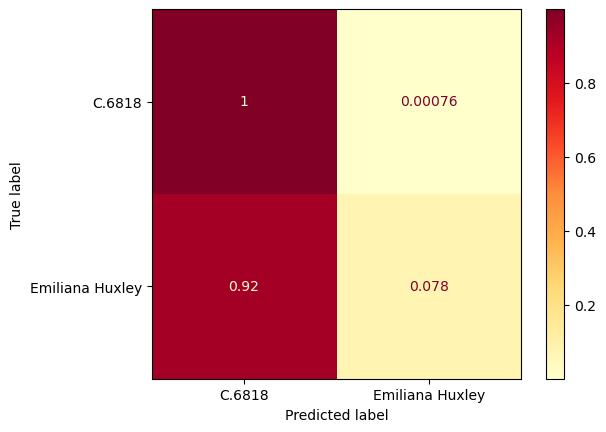

In [30]:
ConfusionMatrixDisplay.from_predictions(
    test_labels, predictions,
    display_labels=target_names,
    normalize="true", cmap="YlOrRd"
)

In [17]:
break here

SyntaxError: invalid syntax (760050616.py, line 1)

In [ ]:
with open("lgb_model_448_cols.bin", mode="wb") as f:
    pickle.dump(lgb_model, f)

# lgb_model.booster_.dump_model(importance_type="split")

: 

In [ ]:
df_model_trees = lgb_model.booster_.trees_to_dataframe()
df_model_trees

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S1,0-S3,None,UV16_(675)-A,22477.000000,1063.500000,<=,left,None,-2.429140e-08,0.000000,261039
1,0,2,0-S1,0-S5,0-S2,0-S0,UV16_(675)-A,30118.400391,-921.500000,<=,left,None,-7.566190e-03,31049.900000,226259
2,0,3,0-S5,0-L0,0-S14,0-S1,UV16_(675)-A,1115.760010,-1209.500000,<=,left,None,3.298970e-02,5925.630000,26571
3,0,4,0-L0,None,None,0-S5,None,NaN,NaN,None,None,None,3.735266e-02,4731.023384,19788
4,0,4,0-S14,0-L6,0-L15,0-S5,LightLoss_(Violet)-H,308.684998,556.500000,<=,left,None,1.571520e-02,1194.610000,6783
5,0,5,0-L6,None,None,0-S14,None,NaN,NaN,None,None,None,4.683230e-03,549.188896,3537
6,0,5,0-L15,None,None,0-S14,None,NaN,NaN,None,None,None,2.507724e-02,645.419929,3246
7,0,3,0-S2,0-S4,0-S6,0-S1,LightLoss_(Violet)-H,8918.740234,739.500000,<=,left,None,-1.713240e-02,25124.300000,199688
8,0,4,0-S4,0-S10,0-S7,0-S2,Max_Intensity_(Green*),1422.380005,157.500000,<=,left,None,-2.363260e-02,19362.500000,162591
9,0,5,0-S10,0-S13,0-L11,0-S4,UV16_(675)-A,432.553009,742.500000,<=,left,None,-2.812860e-02,11472.600000,99903


In [ ]:
df_model_trees.to_csv("model_trees.csv", index=False)

: 

In [ ]:
from IPython.display import HTML

graph = lgb.create_tree_digraph(
    lgb_model,
    tree_index=100,
    max_category_values=10,
    show_info=["split_gain"]
)
with open("model_tree_graph.svg", mode="w") as f:
    f.write(graph._repr_image_svg_xml())

HTML(graph._repr_image_svg_xml())

: 

In [ ]:
with open("lgb_model_448_cols.bin", mode="rb") as f:
    lgb_model = pickle.load(f)

: 

In [ ]:
# hist, bins = lgb_model.booster_.get_split_value_histogram("SSC_(Imaging)-T")
hist, bins = lgb_model.booster_.get_split_value_histogram("UV16_(675)-A")
plt.bar(bins[:-1], hist, width=0.9)

: 

In [ ]:
hist

: 

: 